In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pylab as plt
import seaborn as sns
import pandas as pd
import imblearn
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
Beans = pd.read_excel('DryBeanDataSet.xlsx')
Beans.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,Constantness,EquivDiameter,Colour,...,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,ShapeFactor5,ShapeFactor6,Class,Sort order
0,84648,1132.054,439.915710,248.961941,1.767000,0.824453,86779,1,328.294351,brown,...,0.830027,0.746266,0.005197,0.000994,0.556914,3.487008,0.984066,50.809833,CALI,0.134791
1,39704,736.873,271.659919,186.481404,1.456767,0.727175,40106,1,224.839282,black,...,0.918880,0.82765,0.006842,0.001980,0.685004,1.242335,0.997891,148.508874,DERMASON,0.898848
2,35835,687.914,237.704180,192.176759,1.236904,0.588537,36190,1,213.603696,green,...,0.951588,0.898611,0.006633,0.002668,0.807503,2.813489,0.998803,82.107117,SEKER,0.539684
3,223035,1817.278,680.812555,419.994347,1.621004,0.787040,225889,1,532.894907,brown,...,0.848673,0.782734,0.003052,0.000707,0.612672,3.074472,0.993144,147.347735,BOMBAY,0.149130
4,41957,767.143,287.962974,186.166695,1.546802,0.762918,42310,1,231.130508,brown,...,0.895904,0.80264,0.006863,0.001757,0.644230,2.213954,0.996497,22.893826,SIRA,0.447635


In [4]:
Beans["Colour"] = Beans["Colour"].astype('category')
Beans["Constantness"] = pd.to_numeric(Beans["Constantness"], errors='coerce')
Beans["Class"] = Beans["Class"].astype('category')
Beans["Extent"] = pd.to_numeric(Beans["Extent"], errors='coerce')
Beans["Compactness"] = pd.to_numeric(Beans["Compactness"], errors='coerce')
Beans["ShapeFactor6"] = pd.to_numeric(Beans["ShapeFactor6"], errors='coerce')
Beans["Class"].replace('?', np.nan, inplace=True)
Beans["Colour"].replace('?', np.nan, inplace=True)

In [5]:
Beans.isna().sum()

Area                0
Perimeter           0
MajorAxisLength     0
MinorAxisLength     0
AspectRation        0
Eccentricity        0
ConvexArea          0
Constantness        0
EquivDiameter       0
Colour              6
Extent              6
Solidity            0
roundness           0
Compactness        18
ShapeFactor1        0
ShapeFactor2        0
ShapeFactor3        0
ShapeFactor4        0
ShapeFactor5        0
ShapeFactor6        5
Class              17
Sort order          0
dtype: int64

In [6]:
Beans.dtypes

Area                  int64
Perimeter           float64
MajorAxisLength     float64
MinorAxisLength     float64
AspectRation        float64
Eccentricity        float64
ConvexArea            int64
Constantness          int64
EquivDiameter       float64
Colour             category
Extent              float64
Solidity            float64
roundness           float64
Compactness         float64
ShapeFactor1        float64
ShapeFactor2        float64
ShapeFactor3        float64
ShapeFactor4        float64
ShapeFactor5        float64
ShapeFactor6        float64
Class              category
Sort order          float64
dtype: object

In [7]:
mask = Beans['Colour'].isna()
Beans_encoded = pd.get_dummies(Beans, columns=['Colour'], dtype=float)
Beans_encoded.iloc[mask, Beans_encoded.columns.str.startswith('Colour_')] = np.nan
Beans_encoded.isna().sum()

Area                0
Perimeter           0
MajorAxisLength     0
MinorAxisLength     0
AspectRation        0
Eccentricity        0
ConvexArea          0
Constantness        0
EquivDiameter       0
Extent              6
Solidity            0
roundness           0
Compactness        18
ShapeFactor1        0
ShapeFactor2        0
ShapeFactor3        0
ShapeFactor4        0
ShapeFactor5        0
ShapeFactor6        5
Class              17
Sort order          0
Colour_black        6
Colour_brown        6
Colour_green        6
Colour_white        6
dtype: int64

In [8]:
Beans_encoded = Beans_encoded.drop([2762, 3941, 4780, 5884])
Beans_encoded = Beans_encoded.reset_index(drop=True)

## Resample the data set and then apply normalization.

In [9]:
Beans_missing = Beans_encoded[Beans_encoded.isna().any(axis=1)]
Beans_missing.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,Constantness,EquivDiameter,Extent,...,ShapeFactor3,ShapeFactor4,ShapeFactor5,ShapeFactor6,Class,Sort order,Colour_black,Colour_brown,Colour_green,Colour_white
6,44787,861.814,344.333903,166.179732,2.072057,0.875834,45406,1,238.798198,0.812920,...,0.480953,1.522022,0.996562,25.541389,NaN,0.678889,0.0,1.0,0.0,0.0
104,48479,836.757,312.354576,199.059288,1.569153,0.770627,49080,0,248.445930,0.678398,...,0.632657,2.705577,0.992735,99.847826,SIRA,0.923518,0.0,1.0,0.0,0.0
118,42432,776.089,290.071712,187.172173,1.549759,0.763962,42908,1,232.435153,0.756957,...,0.642086,1.117294,0.995078,126.833659,NaN,0.770406,0.0,1.0,0.0,0.0
436,41708,775.920,292.968805,181.913240,1.610486,0.783866,42212,1,230.443648,0.689218,...,0.618709,2.961417,0.996423,111.802204,NaN,0.729772,0.0,1.0,0.0,0.0
484,76489,1079.856,423.766238,234.103967,1.810163,0.833555,78182,0,312.071818,0.680053,...,0.542321,2.856135,0.981689,103.156493,CALI,0.942229,0.0,1.0,0.0,0.0


In [10]:
Beans_encoded = Beans_encoded.dropna()
Beans_encoded = Beans_encoded.reset_index(drop=True)
Beans_encoded

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,Constantness,EquivDiameter,Extent,...,ShapeFactor3,ShapeFactor4,ShapeFactor5,ShapeFactor6,Class,Sort order,Colour_black,Colour_brown,Colour_green,Colour_white
0,84648,1132.054,439.915710,248.961941,1.767000,0.824453,86779,1,328.294351,0.767184,...,0.556914,3.487008,0.984066,50.809833,CALI,0.134791,0.0,1.0,0.0,0.0
1,39704,736.873,271.659919,186.481404,1.456767,0.727175,40106,1,224.839282,0.757739,...,0.685004,1.242335,0.997891,148.508874,DERMASON,0.898848,1.0,0.0,0.0,0.0
2,35835,687.914,237.704180,192.176759,1.236904,0.588537,36190,1,213.603696,0.790885,...,0.807503,2.813489,0.998803,82.107117,SEKER,0.539684,0.0,0.0,1.0,0.0
3,223035,1817.278,680.812555,419.994347,1.621004,0.787040,225889,1,532.894907,0.761092,...,0.612672,3.074472,0.993144,147.347735,BOMBAY,0.149130,0.0,1.0,0.0,0.0
4,41957,767.143,287.962974,186.166695,1.546802,0.762918,42310,1,231.130508,0.721543,...,0.644230,2.213954,0.996497,22.893826,SIRA,0.447635,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13550,23018,578.382,203.761000,144.297607,1.412089,0.706041,23465,1,171.194123,0.781994,...,0.705888,2.197446,0.996776,85.821969,DERMASON,0.764478,1.0,0.0,0.0,0.0
13551,69773,1095.057,387.116310,231.153291,1.674717,0.802155,71055,1,298.056610,0.762446,...,0.592809,1.004792,0.992787,152.980591,BARBUNYA,0.679735,0.0,1.0,0.0,0.0
13552,55773,968.988,347.920243,204.491191,1.701395,0.809040,57047,0,266.481499,0.765377,...,0.586644,2.219590,0.998113,102.437378,BARBUNYA,0.946849,0.0,1.0,0.0,0.0
13553,64235,1005.875,409.304636,201.686606,2.029409,0.870169,65018,1,285.983465,0.773990,...,0.488190,2.078504,0.990736,174.754039,HOROZ,0.046135,0.0,0.0,0.0,1.0


In [11]:
X = Beans_encoded.drop(['Sort order', 'Class'], axis = 1)
y = Beans_encoded['Class']

smote = SMOTE(random_state=42)
tomek = TomekLinks()

pipeline = Pipeline(steps=[('tomek', tomek), ('smote', smote)])

X_resampled, y_resampled = pipeline.fit_resample(X,np.asarray(y))

X_beans = pd.concat([X_resampled, Beans_missing.drop(['Sort order', 'Class'], axis = 1)])
y_beans = pd.concat([pd.Series(y_resampled), pd.Series(Beans_missing['Class'])])
X_beans = X_beans.reset_index(drop=True)
y_beans = y_beans.reset_index(drop=True)

In [12]:
X_cat = X_beans[["Constantness", "Colour_black", "Colour_brown", "Colour_green", "Colour_white"]]
X_num = X_beans.drop(["Constantness", "Colour_black", "Colour_brown", "Colour_green", "Colour_white"], axis=1)

X_standard = (X_num-X_num.mean())/X_num.std()
X_beans = pd.concat([X_standard, X_cat], axis=1)

In [13]:
y_beans = pd.Series(y_beans, name="Class")
Big_beans = pd.concat([X_beans, y_beans], axis=1)
X_missing = Big_beans[Big_beans["Class"].isna()]
X_missing = X_missing.drop(["Class"],axis=1)

Cleaned_beans = Big_beans.dropna(subset=["Class"])
X_cleaned = Cleaned_beans.drop(["Class"], axis=1)
y_cleaned = Cleaned_beans["Class"]

Beans_df = Cleaned_beans.dropna()
X_subset = Beans_df.drop(["Class"], axis=1)
y_subset = Beans_df["Class"]

class_mapping = {
    "DERMASON": 0,
    "SEKER": 1,
    "BOMBAY": 2,
    "CALI": 3,
    "SIRA": 4,
    "HOROZ": 5,
    "BARBUNYA": 6
}

# Relabel the classes in y_subset
y_subset = y_subset.replace(class_mapping)

In [59]:
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
# Suppress the specific warning
warnings.filterwarnings("ignore", message="X does not have valid feature names")

Beans_subset = X_subset.copy()
best_subset = []
n = X_beans.shape[1]-1

while n != 0:
    RSS = np.inf
    curr_subset = None
    for i in Beans_subset.columns:
        temp_subset = Beans_subset.drop(i, axis=1)

        X_train, X_test, y_train, y_test = train_test_split(temp_subset, y_subset, test_size=0.2, random_state=42)

        knn_subset = KNeighborsClassifier(n_neighbors=135)
        knn_subset.fit(X_train, y_train)

        y_pred = knn_subset.predict(np.asarray(X_test))

        temp_rss = ((y_test-y_pred)**2).sum()
        if temp_rss < RSS:
            RSS = temp_rss
            curr_subset = temp_subset
    best_subset.append(curr_subset)
    Beans_subset = curr_subset
    n -= 1

In [60]:
best_subset

[           Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
 0     -0.654939  -0.790228        -0.797362        -0.615384     -0.581271   
 1     -0.739157  -0.955827        -1.094012        -0.529998     -1.476344   
 2      3.335741   2.864146         2.777144         2.885483      0.087348   
 3     -0.765366  -1.016352        -1.167112        -0.526630     -1.659271   
 4     -0.802153  -0.931153        -0.941845        -0.942209     -0.205046   
 ...         ...        ...              ...              ...           ...   
 22423 -0.415495  -0.399249        -0.346196        -0.406379      0.059215   
 22424 -0.530101  -0.553827        -0.449921        -0.609149      0.273842   
 22425 -0.761600  -0.841762        -0.929973        -0.812617     -0.475811   
 22426 -0.595731  -0.664021        -0.678212        -0.564531     -0.394410   
 22427 -0.470610  -0.510088        -0.513192        -0.378218     -0.388801   
 
        Eccentricity  ConvexArea  EquivDiameter   

In [61]:
mean_scores = []
std_scores = []
for i in range(1, len(best_subset)):

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = KNeighborsClassifier(n_neighbors=135)

    score = cross_val_score(model, np.asarray(X_subset[best_subset[i].columns]), y_subset, cv=kf, scoring='accuracy')
    mean_score = score.mean()
    std_score = score.std()
    
    mean_scores.append(mean_score)
    std_scores.append(std_score)

In [62]:
std_scores

[0.00025954670990085185,
 0.0008338811537614037,
 0.0005373086931071524,
 0.0014338647198091227,
 0.0011476747887609368,
 0.0007095960956723799,
 0.0008563912028445254,
 0.001059584804618924,
 0.0011053252010691324,
 0.000960220822588515,
 0.001754332163255218,
 0.0015583928399548425,
 0.0011159411285209357,
 0.001003552191761115,
 0.0011156163496580367,
 0.001132888189888548,
 0.0010958300634920347,
 0.001384030748345292,
 0.004541806463737285,
 0.005875835075433793,
 0.010292193999058057]

In [63]:
mean_cv_errors = []
std_errors = []

for i in range(len(mean_scores)):
    std_error = std_scores[i] / np.sqrt(5)
    mean_cv_error = 1 - mean_scores[i]
    mean_cv_errors.append(mean_cv_error)
    std_errors.append(std_error)

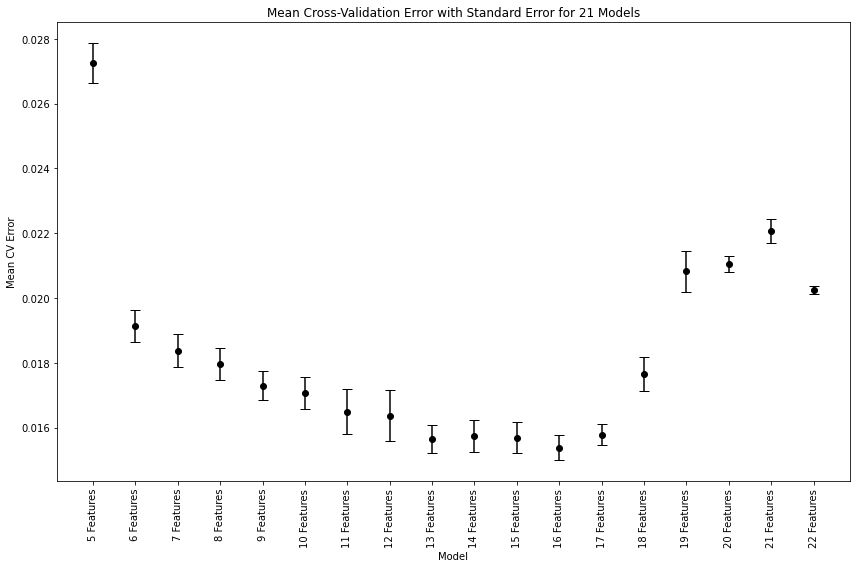

In [64]:
models = [f'{i+5} Features' for i in range(18)]
mean_cv_errors_reversed = mean_cv_errors[0:18][::-1]
std_errors_reversed = std_errors[0:18][::-1]

plt.figure(figsize=(12, 8))
plt.errorbar(models, mean_cv_errors_reversed, yerr=std_errors_reversed, fmt='o', ecolor='black', capsize=5, label='Mean CV Error',  markerfacecolor='black', markeredgecolor = 'black')
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel('Mean CV Error')
plt.title('Mean Cross-Validation Error with Standard Error for 21 Models')
# plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
best_beans = best_subset[9]
best_beans

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,EquivDiameter,roundness,ShapeFactor3,ShapeFactor5,Colour_black,Colour_brown,Colour_green,Colour_white
0,-0.654939,-0.790228,-0.797362,-0.615384,-0.581271,-0.717037,0.932778,0.486392,0.774447,1.0,0.0,0.0,0.0
1,-0.739157,-0.955827,-1.094012,-0.529998,-1.476344,-0.849320,1.481964,1.727123,0.984099,0.0,0.0,1.0,0.0
2,3.335741,2.864146,2.777144,2.885483,0.087348,2.909893,-0.246050,-0.246230,-0.317411,0.0,1.0,0.0,0.0
3,-0.765366,-1.016352,-1.167112,-0.526630,-1.659271,-0.891929,1.780901,2.039610,1.096974,0.0,0.0,1.0,0.0
4,-0.802153,-0.931153,-0.941845,-0.942209,-0.205046,-0.953008,-0.115003,0.075069,0.864577,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22423,-0.415495,-0.399249,-0.346196,-0.406379,0.059215,-0.372708,0.227461,-0.190152,0.484772,0.0,1.0,0.0,0.0
22424,-0.530101,-0.553827,-0.449921,-0.609149,0.273842,-0.532287,0.236555,-0.406657,-0.087458,0.0,1.0,0.0,0.0
22425,-0.761600,-0.841762,-0.929973,-0.812617,-0.475811,-0.885738,-0.391031,0.392526,0.764136,0.0,1.0,0.0,0.0
22426,-0.595731,-0.664021,-0.678212,-0.564531,-0.394410,-0.627856,0.439252,0.270510,0.611276,0.0,1.0,0.0,0.0


In [66]:
from sklearn.model_selection import GridSearchCV

k = 5

clf = GridSearchCV(KNeighborsClassifier(), {
    'n_neighbors': list(range(85, 185, 2))
}, cv=k, return_train_score=True)

clf.fit(best_beans, y_subset)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [85, 87, 89, 91, 93, 95, 97, 99, 101,
                                         103, 105, 107, 109, 111, 113, 115, 117,
                                         119, 121, 123, 125, 127, 129, 131, 133,
                                         135, 137, 139, 141, 143, ...]},
             return_train_score=True)

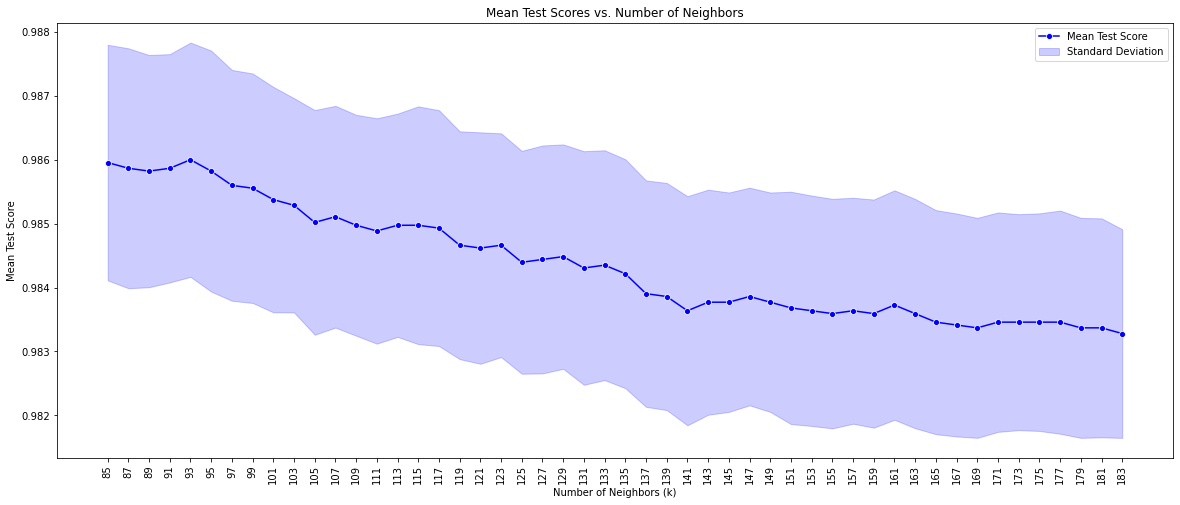

In [67]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=clf.param_grid['n_neighbors'], y=clf.cv_results_['mean_test_score'], marker='o', label='Mean Test Score', color='blue')
plt.fill_between(clf.param_grid['n_neighbors'], 
                 [m - s for m, s in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score']/np.sqrt(k))], 
                 [m + s for m, s in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score']/np.sqrt(k))], 
                 color='blue', alpha=0.2, label='Standard Deviation')

plt.title('Mean Test Scores vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Test Score')
plt.xticks(rotation=90)
plt.xticks(clf.param_grid['n_neighbors'])
# plt.grid(True)
plt.legend()
plt.show()

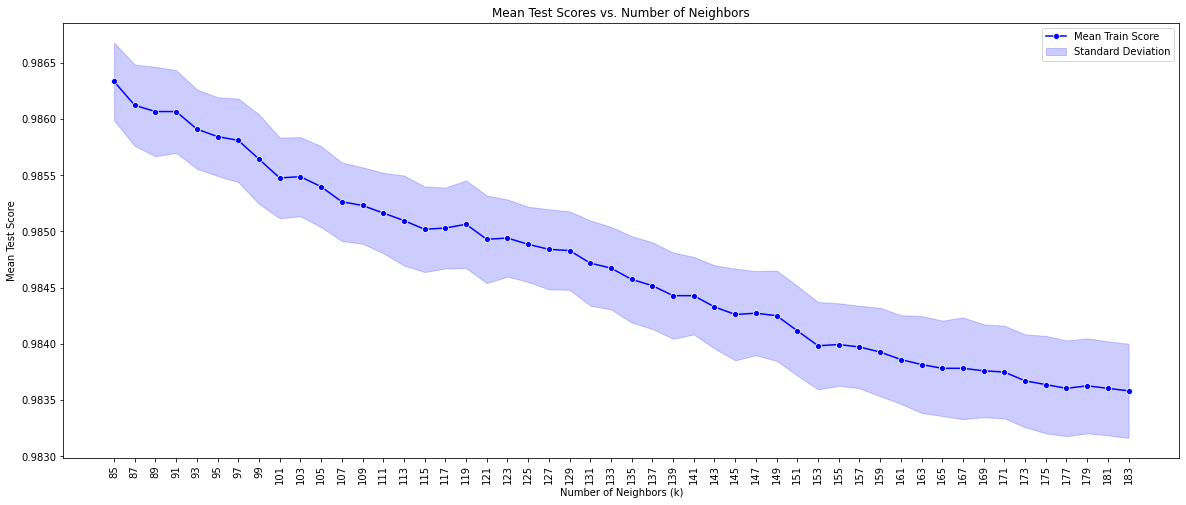

In [68]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=clf.param_grid['n_neighbors'], y=clf.cv_results_['mean_train_score'], marker='o', label='Mean Train Score', color='blue')
plt.fill_between(clf.param_grid['n_neighbors'], 
                 [m - s for m, s in zip(clf.cv_results_['mean_train_score'], clf.cv_results_['std_train_score']/np.sqrt(k))], 
                 [m + s for m, s in zip(clf.cv_results_['mean_train_score'], clf.cv_results_['std_train_score']/np.sqrt(k))], 
                 color='blue', alpha=0.2, label='Standard Deviation')

plt.title('Mean Test Scores vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Test Score')
plt.xticks(rotation=90)
plt.xticks(clf.param_grid['n_neighbors'])
# plt.grid(True)
plt.legend()
plt.show()

In [69]:
from MyKNN import KNN
X_train, X_test, y_train, y_test = train_test_split(X_cleaned[best_beans.columns], y_cleaned, test_size=0.2, random_state=0)

knn_subset = KNN(n_neighbors=133)
knn_subset.fit(X_train, y_train)

In [70]:
y_pred = knn_subset.predict(np.asarray(X_missing[best_beans.columns]))

y_pred

Computing Distances: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.52it/s]


array(['HOROZ', 'SIRA', 'SIRA', 'BARBUNYA', 'BARBUNYA', 'SIRA', 'SEKER',
       'CALI', 'SIRA', 'BARBUNYA', 'BARBUNYA', 'SIRA', 'SIRA', 'BOMBAY',
       'CALI', 'SIRA', 'BARBUNYA'], dtype='<U8')

In [ ]:
# from MyKNN import KNN
y_pred = knn_subset.predict(np.asarray(X_test))
(y_test - y_pred)/len(y_test)

Computing Distances:  98%|███████████████████████████████████████████████████████▋ | 4388/4493 [32:54<00:53,  1.97it/s]